In [1]:
import sys
sys.path.insert(0, '//home/apprenant/PycharmProjects/turnover/')
# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression


In [2]:
df_train = pd.read_csv('../data/attrition_train.csv')
df_test = pd.read_csv('../data/attrition_test.csv')

In [3]:
df_rendu = df_test[['index1']]

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df_train = df_train[df_train.columns.difference(['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18'])]
df_test = df_test[df_test.columns.difference(['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18', 'index1'])]

In [6]:
catg = df_train.select_dtypes(include=[object]).columns.difference(['Attrition'])

print(catg)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')


In [7]:
le = LabelEncoder()

encoded_catg = pd.DataFrame()
for col in catg:
    if len(df_train[col].unique()) <= 2:
        le.fit(df_train[col])
        df_train[col] = le.transform(df_train[col])
    else:
        encoded_catg = pd.concat([encoded_catg, pd.get_dummies(df_train[col], prefix=col)], axis=1)

In [8]:
catg = df_test.select_dtypes(include=[object])
encoded_catg_test = pd.DataFrame()
for col in catg:
    if len(df_test[col].unique()) <= 2:
        le.fit(df_test[col])
        df_test[col] = le.transform(df_test[col])
    else:
        encoded_catg_test = pd.concat([encoded_catg_test, pd.get_dummies(df_test[col], prefix=col)], axis=1)  
Xfinal = pd.concat([df_test.select_dtypes(include=['float64', 'int64']), encoded_catg_test], axis=1)

In [10]:
X= pd.concat([df_train.select_dtypes(include=['float64', 'int64']), encoded_catg], axis=1)
y=df_train['Attrition']

In [11]:
y=y.apply(lambda x: 0 if x=="No" else 1)

Traitements à faire subir à la couche d'input : onehotencoder sur les variables catégorielles pour qu'elles puissent être traitées par l'algorithme, puis standardisation (via BatchNormalization)
Traitements à faire subir à la couche d'output : 1 sortie(yes no), activtion : sigmoid, 

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt

In [15]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

In [139]:
from autokeras import StructuredDataClassifier
import kerastuner as kt

In [240]:
sdc = StructuredDataClassifier(
    column_names=None,
    column_types=None,
    num_classes=None,
    multi_label=False,
    loss='binary_crossentropy',
    metrics='AUC',
    project_name="structured_data_classifier2",
    max_trials=100,
    directory=None,
    objective=kt.Objective("auc", direction="max"),
    tuner=None,
    overwrite=False,
    seed=None,
    max_model_size=None,
)


INFO:tensorflow:Reloading Oracle from existing project ./structured_data_classifier2/oracle.json
INFO:tensorflow:Reloading Tuner from ./structured_data_classifier2/tuner0.json


In [268]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 0.5864
Best Validation Accuracy: 0.7472


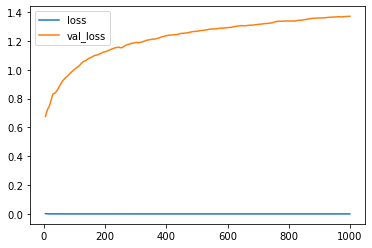

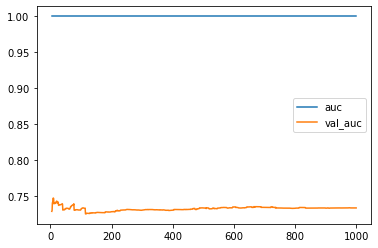

In [269]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['auc', 'val_auc']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_auc'].max()))



In [241]:
sdc.fit(X_train,y_train, validation_data=[X_valid, y_valid])

Trial 32 Complete [00h 00m 07s]
auc: 1.0

Best auc So Far: 1.0000001192092896
Total elapsed time: 00h 05m 30s
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./structured_data_classifier2/best_model/assets


In [242]:
model = sdc.export_model()

In [243]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 49)                0         
_________________________________________________________________
normalization (Normalization (None, 49)                99        
_________________________________________________________________
dense (Dense)                (None, 512)               25600     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312

In [28]:
def plot_roc(y_test, y_pred):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [244]:
y_test = y_valid
y_pred = model.predict(X_valid)

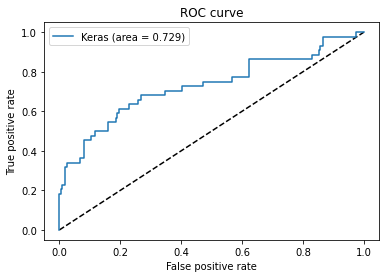

In [245]:
plot_roc(y_test, y_pred)

In [247]:
y_final = model.predict(Xfinal)

In [248]:
for p in y_final:
    if p[0] > 0.5:
        print(p)

[0.73899937]
[0.9926809]
[0.93736565]
[0.9809768]
[0.7810486]
[0.9287407]
[0.674109]
[0.9006786]
[0.668465]
[0.7157796]
[0.86079365]
[0.8297904]
[0.8671051]
[0.8491732]
[0.9051788]
[0.61982745]
[0.6029618]
[0.96850526]
[0.741119]
[0.85654724]
[0.9988482]
[0.931436]
[0.5103543]
[0.8755549]
[0.5990512]
[0.52499646]
[0.9121704]
[0.63913465]
[0.54100114]
[0.616821]
[0.9949932]
[0.66727966]
[0.5241338]
[0.9015851]
[0.98474705]
[0.61630857]
[0.68657017]
[0.9554953]
[0.8111304]
[0.7979377]
[0.93871677]
[0.60688144]
[0.97831106]
[0.7702066]
[0.9551667]


In [249]:
y_final

array([[1.02471113e-02],
       [8.72090459e-03],
       [1.19019896e-01],
       [3.15139890e-02],
       [1.20845437e-03],
       [4.12737936e-01],
       [1.09463334e-02],
       [3.44100893e-02],
       [7.38999367e-01],
       [3.68842483e-03],
       [1.75884664e-02],
       [2.21879482e-02],
       [2.40399539e-02],
       [3.11625001e-07],
       [1.83877349e-03],
       [1.02597475e-03],
       [1.09273424e-04],
       [1.84131503e-01],
       [2.74371505e-02],
       [6.57296181e-03],
       [1.23408437e-02],
       [2.62558460e-04],
       [4.70396668e-01],
       [9.92680907e-01],
       [2.96215564e-01],
       [9.37365651e-01],
       [1.19528174e-03],
       [8.92102718e-04],
       [4.21893865e-01],
       [2.13611126e-03],
       [1.21376535e-04],
       [9.80976820e-01],
       [8.89531948e-05],
       [5.35500050e-03],
       [4.98960912e-01],
       [4.66503501e-02],
       [8.23116302e-03],
       [7.81048596e-01],
       [1.43522024e-03],
       [3.76012325e-02],


In [250]:
y_proba_pred = [[1-p[0], p[0]] for p in y_final]

In [232]:
y_proba_pred

[[0.3067249655723572, 0.69327503],
 [0.9442456960678101, 0.055754304],
 [0.4326496124267578, 0.5673504],
 [0.8934562802314758, 0.10654372],
 [0.9960055351257324, 0.003994465],
 [0.190635085105896, 0.8093649],
 [0.9318526089191437, 0.06814739],
 [0.7577429413795471, 0.24225706],
 [0.5995397567749023, 0.40046024],
 [0.9891084730625153, 0.010891527],
 [0.07496416568756104, 0.92503583],
 [0.8588091135025024, 0.14119089],
 [0.7987898588180542, 0.20121014],
 [0.9998776350985281, 0.0001223649],
 [0.995288759469986, 0.0047112405],
 [0.9996813833713531, 0.00031861663],
 [0.9999896149320193, 1.0385068e-05],
 [0.4417673945426941, 0.5582326],
 [0.2988985776901245, 0.7011014],
 [0.9487287104129791, 0.05127129],
 [0.5590420961380005, 0.4409579],
 [0.9758640825748444, 0.024135917],
 [0.7042259573936462, 0.29577404],
 [0.006624341011047363, 0.99337566],
 [0.02815067768096924, 0.9718493],
 [0.002682507038116455, 0.9973175],
 [0.9639089405536652, 0.03609106],
 [0.9993438422679901, 0.00065615773],
 [0.02

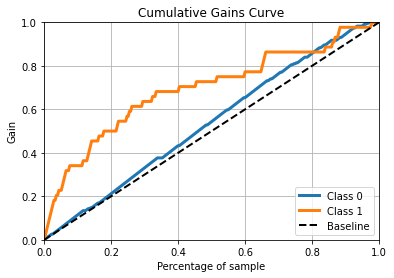

In [259]:
import scikitplot as skplt
y_proba_train = model.predict(X_valid)
y_proba_train_pred = [[1-p[0], p[0]] for p in y_proba_train]
skplt.metrics.plot_cumulative_gain(y_valid, y_proba_train_pred)
plt.show()

In [255]:
y_binary_pred = sdc.predict(Xfinal)

In [235]:
y_binary_pred

array([[1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],

In [236]:
y_binary_pred[:,0]

array([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [256]:
d = {'bin': y_binary_pred[:,0], 'pred': y_final[:,0]}
dframe = pd.DataFrame(d)

In [278]:
df_rendu['ScoreAttrition'] = model.predict(Xfinal)[:,0]
df_rendu['Depart'] = sdc.predict(Xfinal)[:,0]

In [279]:
df_rendu

,index1,ScoreAttrition,Depart
0,0,6.008989e-08,0.0
1,1,3.174368e-07,0.0
2,2,2.843738e-04,0.0
3,3,5.185700e-05,0.0
4,4,5.001942e-07,0.0
...,...,...,...
365,365,3.202443e-11,0.0
366,366,1.316090e-07,0.0
367,367,1.179245e-01,0.0
368,368,9.992029e-01,1.0


In [280]:
df_rendu.to_csv('neural_predictions')